<center><h1>EE69205: Signal Processing System Design</h1></center>
<center><h2>Experiment-6: SVD Based Image Compression</h2></center>
<center><h3>Anirvan Krishna | 21EE38002</h3></center>

In [4]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim, mean_squared_error as mse, peak_signal_noise_ratio as psnr
from skimage.util.shape import view_as_windows
from skimage.util import montage

In [5]:
img = cv2.imread('cameraman.tif')

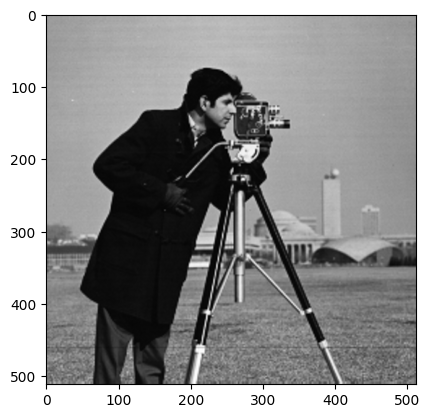

In [6]:
plt.imshow(img, cmap='gray')

# Image Resizing and Scaling

In [7]:
def scale_image(image):
    """
    Scale the pixel values of an image to the range [0, 255].

    Parameters:
    image (numpy.ndarray): The input image to be scaled.

    Returns:
    numpy.ndarray: The scaled image with pixel values in the range [0, 255].
    """
    # Normalize the image to the range [0, 1]
    normalized_image = (image - np.min(image)) / (np.max(image) - np.min(image))
    
    # Scale to the range [0, 255]
    scaled_image = (normalized_image * 255).astype(np.uint8)
    
    return scaled_image

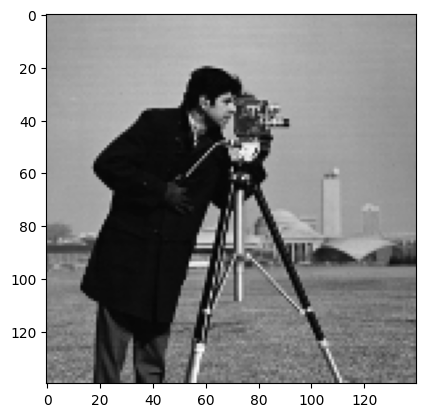

In [8]:
img = cv2.resize(img, (140, 140))
plt.imshow(img, cmap='gray')

# Singular Value Decomposition (SVD)

Singular Value Decomposition (SVD) is a matrix factorization technique that decomposes a matrix $ A $ into three matrices: $ U $, $ \Sigma $, and $ V^T $. Mathematically, $$ A = U \Sigma V^T $$ where $ U $ and $ V $ are orthogonal matrices, and $ \Sigma $ is a diagonal matrix of singular values.

To determine the matrices $ U $ and $ V $ in the SVD equation, we perform the following steps:

1. **Compute the covariance matrix**: For a given matrix $ A $, compute the covariance matrix $ C = A^T A $.
2. **Eigenvalue decomposition**: Perform eigenvalue decomposition on the covariance matrix $ C $ to obtain the eigenvalues and eigenvectors.
3. **Form the matrices**:
    - The matrix $ V $ is formed by the eigenvectors of $ C $.
    - The matrix $ U $ is formed by the normalized projections of $ A $ onto the eigenvectors of $ C $.

Mathematically, this can be represented as:
$$
C = A^T A = V \Lambda V^T
$$
where $ \Lambda $ is the diagonal matrix of eigenvalues. The columns of $ V $ are the eigenvectors of $ C $.

The matrix $ U $ is then given by:
$$
U = A V \Sigma^{-1}
$$
where $ \Sigma $ is the diagonal matrix of singular values, which are the square roots of the eigenvalues in $ \Lambda $.

For any value of K, the image can be reconstructed as:
$$
A' = \sum_{k=1}^{K} U_{(:, k)}\Sigma_{(k)}V^{T}_{(k, :)}
$$

Compression Ratio (CR) for any value of K is defined as:

$$
CR = \frac{K(1 + H + W)}{H W}
$$

In [ ]:
def svd_compress(img_data, rank):
    """
    Compresses an image using SVD by keeping top singular values.

    Parameters:
    img_data (numpy.ndarray): Input image.
    rank (int): Number of singular values to retain.

    Returns:
    numpy.ndarray: Compressed image.
    """
    # Convert image to grayscale if it's in color
    if len(img_data.shape) == 3:
        img_gray = cv2.cvtColor(img_data, cv2.COLOR_BGR2GRAY)
    else:
        img_gray = img_data

    # Apply SVD
    U, S, VT = np.linalg.svd(img_gray, full_matrices=False)

    # Keep only top 'rank' singular values
    U_k, S_k, VT_k = U[:, :rank], np.diag(S[:rank]), VT[:rank, :]
    img_reconstructed = np.dot(U_k, np.dot(S_k, VT_k))

    return img_reconstructed


def reconstruct_images(img, k_max):
    reconstructed_image = 0

    for k in range(1, k_max+1):
        img_compressed = svd_compress(img, k)
        reconstructed_image += img_compressed
    return reconstructed_image

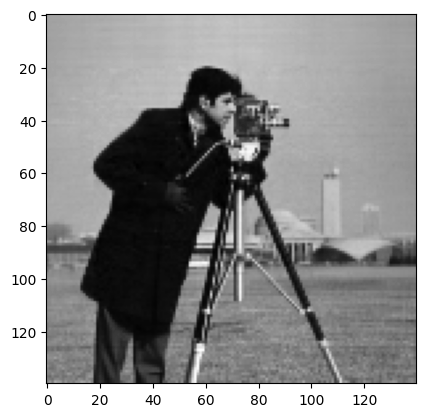

In [20]:
plt.imshow(scale_image(reconstruct_images(img, k_max=140)), cmap='gray')

For k = 5:	PSNR: 8.9275	 SSIM: 0.1312	 MSE: 8323.9361
For k = 10:	PSNR: 9.8462	 SSIM: 0.1542	 MSE: 6736.8633
For k = 20:	PSNR: 9.7368	 SSIM: 0.1605	 MSE: 6908.7801
For k = 40:	PSNR: 9.3258	 SSIM: 0.1609	 MSE: 7594.5118
For k = 50:	PSNR: 9.2435	 SSIM: 0.1597	 MSE: 7739.8051
For k = 100:	PSNR: 9.1539	 SSIM: 0.1625	 MSE: 7901.1088


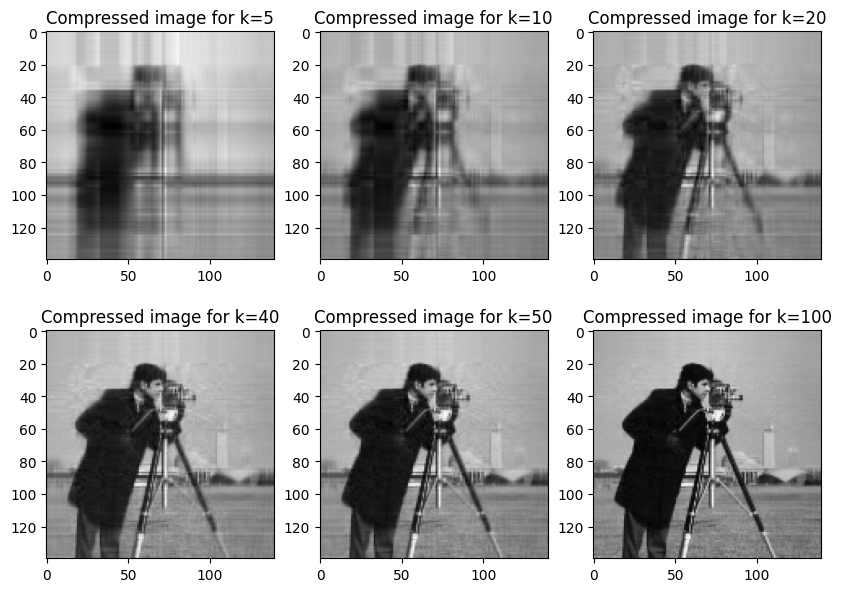

In [21]:
k_values = [5, 10, 20, 40, 50, 100]

psnr_values = []
ssim_values = []
mse_values = []

H = []
W = []

plt.figure(figsize=(10, 11))

# Calculate metrics
for i, k in enumerate(k_values):

    img_compressed = reconstruct_images(img, k)
    H.append(img_compressed.shape[0]), W.append(img_compressed.shape[1])
    img_compressed = scale_image(img_compressed)

    plt.subplot(3, 3, i+1)
    plt.imshow(img_compressed, cmap='gray')
    plt.title(f"Compressed image for k={k}")

    # Check for shape match and resize if needed
    if img_compressed.shape != img.shape:
        img_compressed = np.resize(img_compressed, img.shape)

    psnr_values.append(psnr(img, img_compressed))

    # Specify win_size and channel_axis for SSIM
    ssim_values.append(ssim(img, img_compressed, win_size=5, channel_axis=2))
    mse_values.append(mse(img, img_compressed))
    print(
        f"For k = {k}:\tPSNR: {psnr_values[-1]:.4f}\t SSIM: {ssim_values[-1]:.4f}\t MSE: {mse_values[-1]:.4f}")

In [152]:
def compression_ratio(k, img_compressed):
    H, W = img_compressed.shape[0], img_compressed.shape[1]
    return k * (1 + H + W)/(H*W)

CR = []

for k in k_values:
    CR.append(compression_ratio(k, img_compressed))

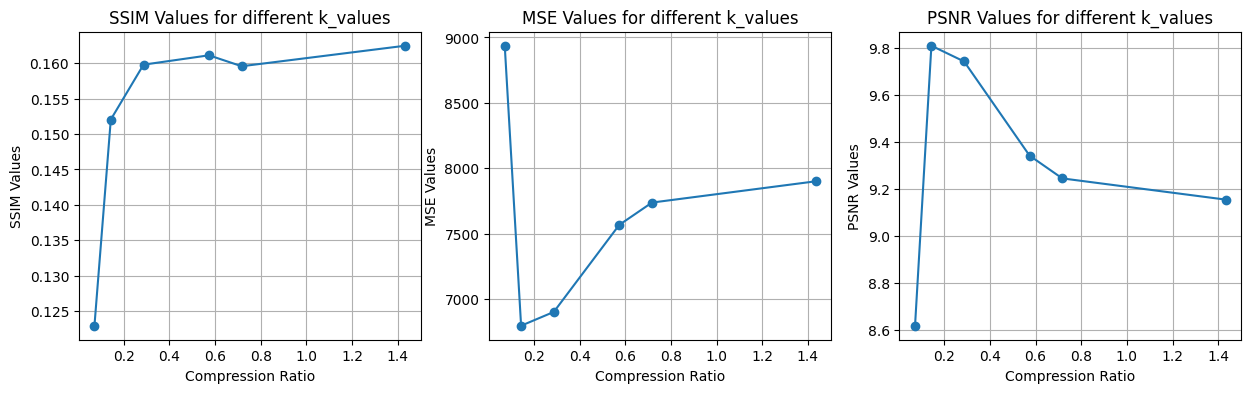

In [153]:
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.plot(CR, ssim_values,marker='o')
plt.xlabel("Compression Ratio")
plt.ylabel("SSIM Values")
plt.title('SSIM Values for different k_values')
plt.grid()

plt.subplot(1, 3, 2)
plt.plot(CR, mse_values, marker='o')
plt.xlabel("Compression Ratio")
plt.ylabel("MSE Values")
plt.title('MSE Values for different k_values')
plt.grid()

plt.subplot(1, 3, 3)
plt.plot(CR, psnr_values, marker='o')
plt.xlabel("Compression Ratio")
plt.ylabel("PSNR Values")
plt.title('PSNR Values for different k_values')
plt.grid()

# Patchwise Image Compression

Images often contain areas with varying levels of detail (e.g., a sky region versus a detailed texture like grass). Patch-wise compression allows different patches to be compressed at different levels of quality based on their detail levels. High-detail patches can be compressed less to preserve quality, while low-detail areas can undergo stronger compression without noticeable quality loss.

## Uniform Patch SVD 

In [154]:
# Ensure the image is grayscale
if len(img.shape) == 3:
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
else:
    img_gray = img

# Define the patch size
patch_size = (28, 28)

# Split the image into non-overlapping patches
patches = view_as_windows(img_gray, patch_size, step=patch_size)

# Reshape patches to have 25 patches of size 28x28
patches = patches.reshape(-1, patch_size[0], patch_size[1])

print(f"Number of patches: {patches.shape[0]}")
print(f"Patch shape: {patches[0].shape}")

Number of patches: 25
Patch shape: (28, 28)


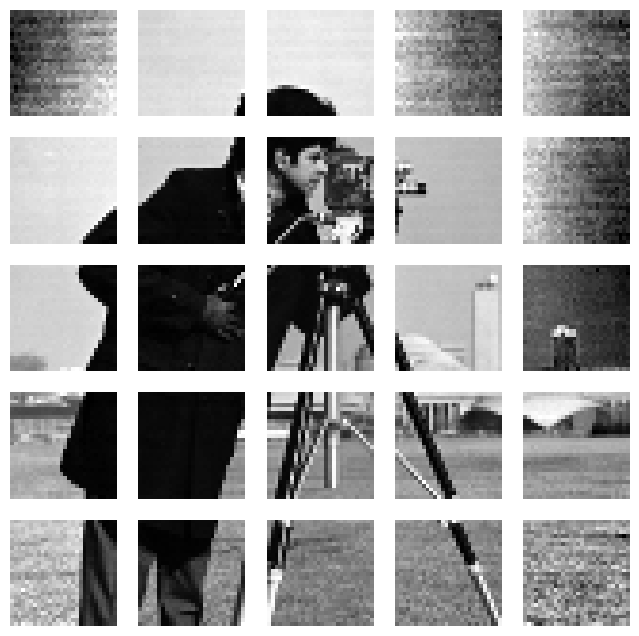

In [155]:
plt.figure(figsize=(8, 8))

for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(patches[i], cmap='gray')
    plt.axis('off')

plt.show()

In [ ]:
k_values = [5, 10, 20, 40, 50, 100]
CR_p = []

compressed_patches = []

for k in k_values:
    for patch in patches:
        compressed_patch = reconstruct_images(patch, k)
        
        scaled_compressed_patch = scale_image(compressed_patch)
        compressed_patches.append(scaled_compressed_patch)

    CR_p.append(compression_ratio(k, compressed_patch))

compressed_patches = np.array(compressed_patches)

In [ ]:
# Initialize a list to store the reconstructed images for each value of K
reconstructed_images = []

mse_patch = []
psnr_patch = []
ssim_patch = []

# Iterate over the k_values
for k in k_values:
    # Extract the patches corresponding to the current value of K
    start_idx = k_values.index(k) * 25
    end_idx = start_idx + 25
    patches_k = compressed_patches[start_idx:end_idx]
    
    # Merge the patches to form the reconstructed image
    reconstructed_image = montage(patches_k, grid_shape=(5, 5), padding_width=0)
    
    # Append the reconstructed image to the list
    reconstructed_images.append(reconstructed_image)

    # Compute PSNR, MSE, and SSIM for the reconstructed image
    mse_patch.append(mse(img_gray, reconstructed_image))
    psnr_patch.append(psnr(img_gray, reconstructed_image))
    ssim_patch.append(ssim(img_gray, reconstructed_image))

    print(f"For k = {k}:\tPSNR: {psnr_patch[-1]:.4f}\t SSIM: {ssim_patch[-1]:.4f}\t MSE: {mse_patch[-1]:.4f}")

For k = 5:	PSNR: 13.5231	 SSIM: 0.5793	 MSE: 2889.1329
For k = 10:	PSNR: 14.2976	 SSIM: 0.6802	 MSE: 2417.2244
For k = 20:	PSNR: 15.1352	 SSIM: 0.7450	 MSE: 1993.2215
For k = 40:	PSNR: 15.7088	 SSIM: 0.7687	 MSE: 1746.6089
For k = 50:	PSNR: 15.8096	 SSIM: 0.7717	 MSE: 1706.5537
For k = 100:	PSNR: 16.0072	 SSIM: 0.7752	 MSE: 1630.6340


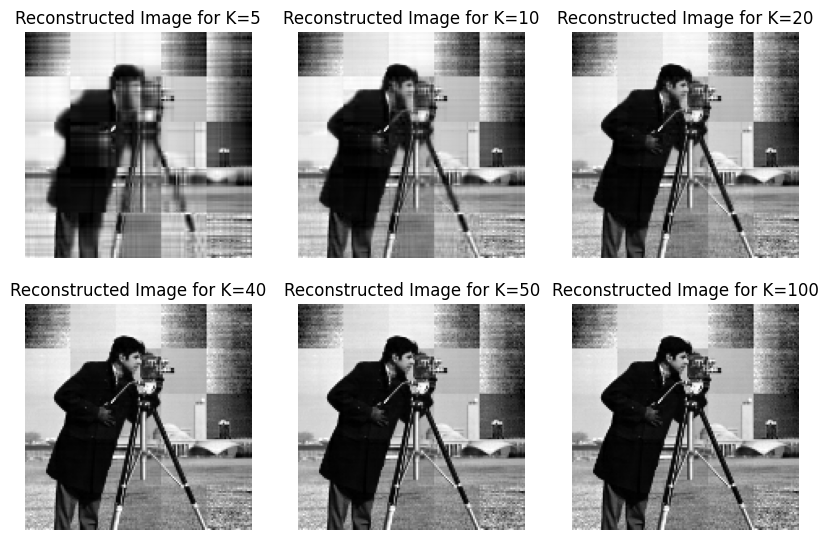

In [158]:
# Display the reconstructed images
plt.figure(figsize=(10, 10))
for i, k in enumerate(k_values):
    plt.subplot(3, 3, i + 1)
    plt.imshow(reconstructed_images[i], cmap='gray')
    plt.title(f'Reconstructed Image for K={k}')
    plt.axis('off')
plt.show()

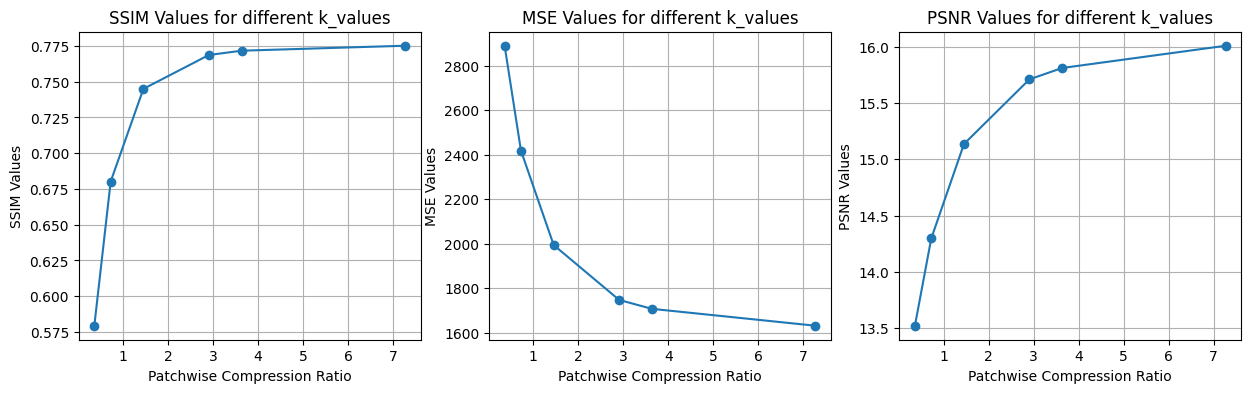

In [159]:
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.plot(CR_p, ssim_patch, marker='o')
plt.xlabel("Patchwise Compression Ratio")
plt.ylabel("SSIM Values")
plt.title('SSIM Values for different k_values')
plt.grid()

plt.subplot(1, 3, 2)
plt.plot(CR_p, mse_patch, marker='o')
plt.xlabel("Patchwise Compression Ratio")
plt.ylabel("MSE Values")
plt.title('MSE Values for different k_values')
plt.grid()

plt.subplot(1, 3, 3)
plt.plot(CR_p, psnr_patch, marker='o')
plt.xlabel("Patchwise Compression Ratio")
plt.ylabel("PSNR Values")
plt.title('PSNR Values for different k_values')
plt.grid()

In [160]:
print("For Patchwise Compression and Reconstruction")
print("-"*30)

for i, k in enumerate(k_values):
    print(
        f"For k = {k}:\tCompression Ratio: {CR_p[i]:.4f}\tPSNR: {psnr_patch[i]:.4f}\tSSIM: {ssim_patch[i]:.4f}\tMSE: {mse_patch[i]:.4f}")
print("\n")

print("For Direct Compression and Reconstruction")
print("-"*30)
for i, k in enumerate(k_values):
    print(
        f"For k = {k}:\tCompression Ratio: {CR[i]:.4f}\tPSNR: {psnr_values[i]:.4f}\tSSIM: {ssim_values[i]:.4f}\tMSE: {mse_values[i]:.4f}")

For Patchwise Compression and Reconstruction
------------------------------
For k = 5:	Compression Ratio: 0.3635	PSNR: 13.5231	SSIM: 0.5793	MSE: 2889.1329
For k = 10:	Compression Ratio: 0.7270	PSNR: 14.2976	SSIM: 0.6802	MSE: 2417.2244
For k = 20:	Compression Ratio: 1.4541	PSNR: 15.1352	SSIM: 0.7450	MSE: 1993.2215
For k = 40:	Compression Ratio: 2.9082	PSNR: 15.7088	SSIM: 0.7687	MSE: 1746.6089
For k = 50:	Compression Ratio: 3.6352	PSNR: 15.8096	SSIM: 0.7717	MSE: 1706.5537
For k = 100:	Compression Ratio: 7.2704	PSNR: 16.0072	SSIM: 0.7752	MSE: 1630.6340


For Direct Compression and Reconstruction
------------------------------
For k = 5:	Compression Ratio: 0.0717	PSNR: 8.6190	SSIM: 0.1229	MSE: 8936.7979
For k = 10:	Compression Ratio: 0.1434	PSNR: 9.8082	SSIM: 0.1521	MSE: 6796.0765
For k = 20:	Compression Ratio: 0.2867	PSNR: 9.7413	SSIM: 0.1598	MSE: 6901.5918
For k = 40:	Compression Ratio: 0.5735	PSNR: 9.3416	SSIM: 0.1611	MSE: 7566.9646
For k = 50:	Compression Ratio: 0.7168	PSNR: 9.2447	SSI

## Adaptive Patchwise Compression

In [161]:
def adaptive_block_size_svd_compression(image, initial_block_size=16, threshold=0.1):
    # Convert the image to grayscale and normalize
    if image.ndim == 3:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray_image = image
    
    gray_image = gray_image / 255.0

    # Get image dimensions
    height, width = gray_image.shape

    # Initialize compressed image storage
    compressed_image = np.zeros((height, width))

    # Define initial block size and iterate over the image
    for i in range(0, height, initial_block_size):
        for j in range(0, width, initial_block_size):
            # Extract block
            block = gray_image[i:i+initial_block_size, j:j+initial_block_size]

            # Determine block complexity (e.g., using variance)
            if np.var(block) > threshold:
                block_size = initial_block_size # High complexity, keep small block size
                k = initial_block_size // 2     # Higher rank for more details
            else:
                block_size = initial_block_size  # Low complexity, increase block size
                k = initial_block_size // 3     # Lower rank for compression

            # Resize block if it exceeds image boundaries
            block = gray_image[i:i+block_size, j:j+block_size]

            # Apply SVD
            U, Sigma, Vt = np.linalg.svd(block, full_matrices=False)

            # Keep only top-k singular values
            U_k = U[:, :k]
            Sigma_k = np.diag(Sigma[:k])
            Vt_k = Vt[:k, :]

            # Reconstruct the block
            compressed_block = np.dot(U_k, np.dot(Sigma_k, Vt_k))

            # Store the compressed block back to image
            compressed_image[i:i+block_size, j:j+block_size] = compressed_block

    # Scale back to 8-bit and return
    compressed_image = np.clip(compressed_image * 255, 0, 255).astype(np.uint8)
    return compressed_image

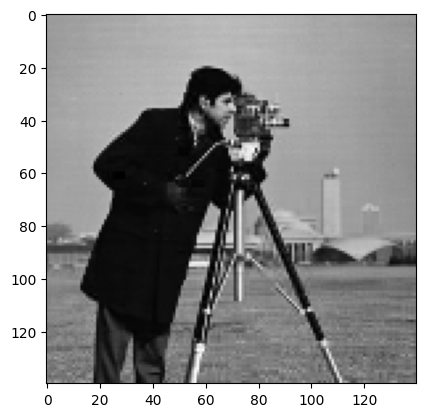

In [162]:
plt.imshow(adaptive_block_size_svd_compression(img, initial_block_size=10, threshold=0.01), cmap='gray')

In [163]:
initial_block_sizes = [4, 8, 16, 32]
thresholds = [0.01, 0.05, 0.1, 0.2]
compressed_images = [[] for _ in range(len(thresholds))]

PSNR = []
MSE = []
SSIM = []

for i, block_size in enumerate(initial_block_sizes):
    print(f"For block size = {block_size}")
    print("-"*45)
    for threshold in thresholds:
        compressed_image = adaptive_block_size_svd_compression(img_gray, initial_block_size=block_size, threshold=threshold)
        compressed_images[i].append(compressed_image)

        # Report MSE, SSIM and PSNR Values for each compressed block size and threshold
        mse_value = mse(img_gray, compressed_image)
        ssim_value = ssim(img_gray, compressed_image)
        psnr_value = psnr(img_gray, compressed_image)
        
        PSNR.append(psnr_value)
        MSE.append(mse_value)
        SSIM.append(ssim_value)

        # create a table for block size threshold and metrics
        print(f"For threshold: {threshold:.4f}")
        print(f"PSNR: {psnr_value:.4f}\tSSIM: {ssim_value:.4f}\tMSE: {mse_value:.4f}\n")         

For block size = 4
---------------------------------------------
For threshold: 0.0100
PSNR: 33.1969	SSIM: 0.9539	MSE: 31.1448

For threshold: 0.0500
PSNR: 28.7251	SSIM: 0.9298	MSE: 87.2110

For threshold: 0.1000
PSNR: 27.2966	SSIM: 0.9213	MSE: 121.1772

For threshold: 0.2000
PSNR: 27.2136	SSIM: 0.9206	MSE: 123.5145

For block size = 8
---------------------------------------------
For threshold: 0.0100
PSNR: 34.7812	SSIM: 0.9643	MSE: 21.6252

For threshold: 0.0500
PSNR: 30.2617	SSIM: 0.9413	MSE: 61.2225

For threshold: 0.1000
PSNR: 28.2310	SSIM: 0.9273	MSE: 97.7187

For threshold: 0.2000
PSNR: 28.2197	SSIM: 0.9272	MSE: 97.9745

For block size = 16
---------------------------------------------
For threshold: 0.0100
PSNR: 36.4612	SSIM: 0.9747	MSE: 14.6879

For threshold: 0.0500
PSNR: 33.1292	SSIM: 0.9579	MSE: 31.6343

For threshold: 0.1000
PSNR: 31.6063	SSIM: 0.9511	MSE: 44.9212

For threshold: 0.2000
PSNR: 31.1087	SSIM: 0.9482	MSE: 50.3741

For block size = 32
--------------------------

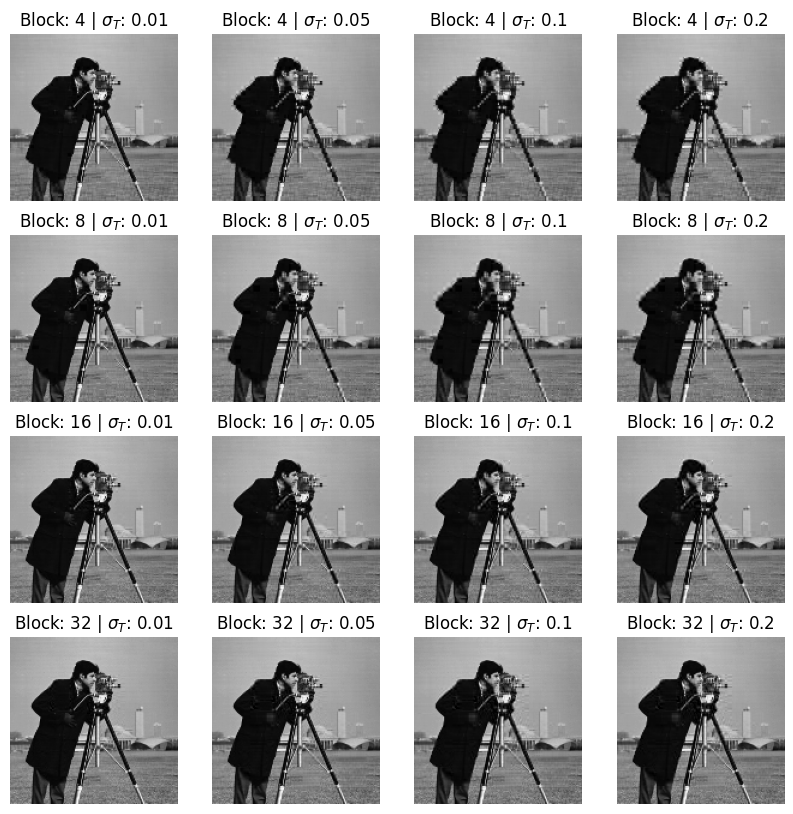

In [164]:
plt.figure(figsize=(10, 10))

for i, images in enumerate(compressed_images):
    for j, img in enumerate(images):
        plt.subplot(4, 4, i * len(images) + j + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"Block: {initial_block_sizes[i]} | $\sigma_T$: {thresholds[j]}")
        plt.axis('off')

In [165]:
plt.imsave('compressed.png', compressed_images[3][0], cmap='gray')